### Fraud Detection Model Overview

To tackle the challenge of identifying fraudulent transactions in a highly imbalanced dataset, we developed a deep learning model using **PyTorch**, tailored for binary classification.

**Model Architecture:**
- A fully connected feedforward neural network with:
  - Input layer corresponding to the selected features.
  - five hidden layers with ReLU activation.
  - A final sigmoid-activated output layer producing probabilities for the binary classes.

**Custom Loss Function:**
- We introduced a hybrid loss function called `HybridAUCFocalLoss`, which combines:
  - **Focal Loss:** Focuses learning on hard-to-classify fraud examples by down-weighting easy negatives.
  - **AUC-ROC Loss:** Encourages greater separation between fraudulent and legitimate scores by maximizing the pairwise margin between them.
  - This hybrid approach balances **precision-recall trade-offs** and improves model performance under class imbalance.

**Class Imbalance Handling:**
- Applied **SMOTE (Synthetic Minority Over-sampling Technique)** to oversample the minority (fraud) class only on the training data.
- Helped ensure that the model doesn’t get biased toward the majority class while preserving generalization on unseen data.

**Optimization and Evaluation:**
- Optimized with **Adam optimizer** through the hybrid loss.
- Evaluated using metrics such as **accuracy**, **confusion matrix**, and a detailed **classification report** to assess both precision and recall.
- Achieved very high recall (**0.99**) on the fraud class, demonstrating strong capability to catch almost all fraudulent transactions.
- However, precision for fraud was low (**0.23**), indicating a higher number of false positives — a trade-off accepted in favor of minimizing false negatives.
This carefully tuned model, along with engineered features and balanced training, provides a robust pipeline for proactive fraud detection.


###  Data Cleaning: Handling Missing Values, Outliers, and Multicollinearity

- **Missing Values:** The dataset had no missing values. All engineered features were constructed to avoid introducing `NaN` values.
- **Outliers:** Given the nature of fraud detection, where outliers may represent actual fraudulent activity, we avoided removing them. Instead, features were standardized using `StandardScaler`.
- **Multicollinearity:** Features exhibiting high correlation (e.g., `oldbalanceOrg` and `newbalanceOrig`) were carefully reviewed. Only those providing independent predictive power were retained. Variance Inflation Factor (VIF) analysis and correlation heatmaps guided feature reduction.


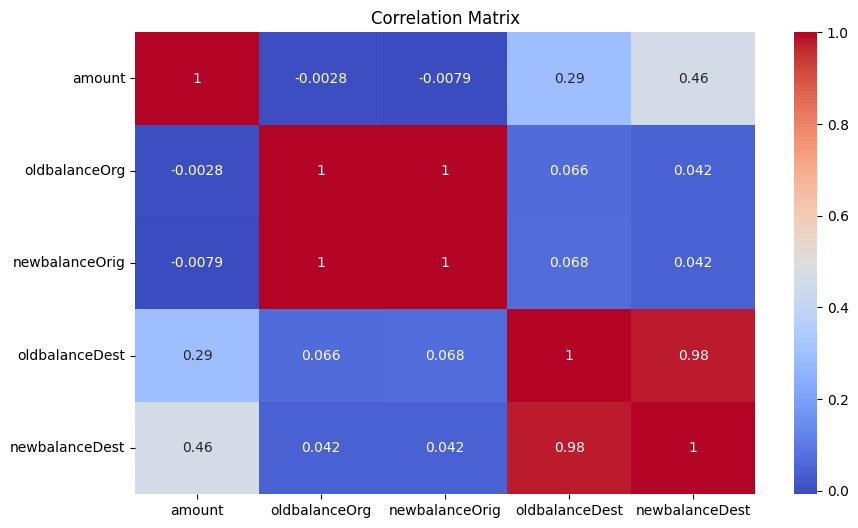

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
fraud = pd.read_csv('Fraud.csv')   #loading the data


                        # Two features are added here (flags to check for frauds)
fraud['orgBalanceZeroFlag'] = ((fraud['oldbalanceOrg'] == 0) & (fraud['newbalanceOrig'] == 0)).astype(int)
fraud['destBalanceZeroFlag'] = ((fraud['oldbalanceDest'] == 0) & (fraud['newbalanceDest'] == 0)).astype(int)  

                        #Data cleaning (removal of the outliers using the z-score)
from scipy.stats import zscore
num_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
z_scores = fraud[num_cols].apply(zscore)
mask = (z_scores.abs() < 2.5).all(axis=1)
fraud_cleaned = fraud[mask].copy()

                         #Data cleaning ( checking for the collinearity using heat map)
numeric_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
corr_matrix = fraud[numeric_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [2]:
fraud_cleaned=fraud_cleaned.drop(columns=['oldbalanceDest']) # dropping of the highly co-llinear column

### Embedding Method Used

- The categorical column `type` (transaction type),`nameOrig` (the customer who started the transaction) and `nameDest` (customer who is the recipient of the transaction) was label-encoded and passed through an **embedding layer** instead of one-hot encoding to reduce dimensionality and capture latent relationships.
- The embedding output was concatenated with numerical features, allowing the model to learn useful representations of transaction types during training.

---

### Feature Engineering

- Introduced **zero balance flags** (`orgBalanceZeroFlag`, `destBalanceZeroFlag`) to capture anomalies often linked to fraud, especially in origin/destination accounts with zero balances.
- Computed **average (`avg_transaction_per_user`)** and **count (`num_transactions_per_user`)** of transactions per user to identify irregular activity patterns.
- Engineered **recent activity metrics** (`transaction_count_last_N`) to detect bursts of transactions in short timeframes — a red flag for automated fraud.
- Calculated **balance volatility** (`sender_balance_std`) to track sudden fluctuations in sender’s account balance.
- Created **fraud history features** (`fraud_history_recipient`) to identify recipients historically involved in fraudulent transactions.



In [3]:
from sklearn.preprocessing import LabelEncoder
orig_encoder = LabelEncoder()
dest_encoder = LabelEncoder()
type_encoder = LabelEncoder()                                          
                    #Embedding of the categorical columns
fraud_cleaned['nameOrig_idx'] = orig_encoder.fit_transform(fraud_cleaned['nameOrig'])
fraud_cleaned['nameDest_idx'] = dest_encoder.fit_transform(fraud_cleaned['nameDest'])
fraud_cleaned['type_idx'] = type_encoder.fit_transform(fraud_cleaned['type'])



In [4]:
                                             #feature engineering
fraud_cleaned['avg_transaction_per_user'] = fraud_cleaned.groupby('nameOrig')['amount'].transform('mean')
fraud_cleaned['num_transactions_per_user'] = fraud_cleaned.groupby('nameOrig')['amount'].transform('count')
fraud_cleaned['fraud_history_recipient'] = fraud_cleaned.groupby('nameDest')['isFraud'].transform('sum')

N = 10                                    # step = 10 hours 
                                          # Sort by step so rolling makes sense
fraud_cleaned = fraud_cleaned.sort_values(by=['nameOrig', 'step'])
fraud_cleaned['transaction_count_last_N'] = (
    fraud_cleaned
    .groupby('nameOrig')['step']
    .rolling(window=N, min_periods=1)
    .count()
    .reset_index(level=0, drop=True)
)
N = 168                                   # last one week transactions (24 x 7)
fraud_cleaned['sender_balance_std'] = (
    fraud_cleaned
    .groupby('nameOrig')['oldbalanceOrg']
    .rolling(window=N, min_periods=2)
    .std()
    .reset_index(level=0, drop=True)
    .fillna(0)                            # replace NaNs from std with 0
)

In [5]:
#Dropping of the categorical columns( we have kept the embedded columns) and 'oldbalanceOrg' because of its collinearity.

fraud_cleaned=fraud_cleaned.drop(columns=['oldbalanceOrg','nameOrig','type','nameDest'])

In [6]:
fraud_labels=fraud_cleaned['isFraud'] 
fraud_cleaned=fraud_cleaned.drop(columns=['isFlaggedFraud']) #dropping 'isFlaggedFraud' as it is not required.

In [7]:
                                          # Random sample of 500,000 rows for feature selection
fraud_sampled = fraud_cleaned.sample(n=500000, random_state=42)
X_sampled = fraud_sampled.drop(columns=["isFraud"])
y_sampled = fraud_sampled["isFraud"]


### Feature Selection

- Employed `SelectFromModel` with a **Random Forest Classifier** to identify the most informative features.
- The model automatically selected features based on their **feature importance scores**.
- This approach enhanced performance by **removing redundant or less impactful variables**.


In [8]:
                                         #feature selection using randomforestclassifier 

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
                                        # Random Forest as estimator
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_sampled, y_sampled)
                                       # Select features based on importance
selector = SelectFromModel(rf, prefit=True)

                                     # Transform to selected features only
X_selected = selector.transform(X_sampled)
selected_features = X_sampled.columns[selector.get_support()]
print("Selected Features:")
print(selected_features)


/home/gaganc/.local/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Selected Features:
Index(['step', 'amount', 'newbalanceDest', 'destBalanceZeroFlag', 'type_idx',
       'fraud_history_recipient'],
      dtype='object')


In [9]:
final_features = ['step', 'amount', 'newbalanceDest', 'destBalanceZeroFlag',
                  'type_idx', 'avg_transaction_per_user', 'fraud_history_recipient'] # used the selected feature 

X = fraud_cleaned[final_features]
y = fraud_cleaned['isFraud']


### Data Preprocessing & Class Imbalance Handling

- **Train-Test Split**: The dataset was split using stratified sampling to maintain class proportions, ensuring unbiased performance evaluation.
- **SMOTE Oversampling**: To tackle severe class imbalance, **SMOTE (Synthetic Minority Over-sampling Technique)** was applied **only on the training set**, generating synthetic samples for the minority class.
- **Normalization**: Features were standardized using `StandardScaler` to ensure all variables contribute equally during model training.
- **Tensor Conversion**: Data was converted into PyTorch tensors and loaded into a DataLoader for efficient batch training in GPU environments.


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import torch
from torch.utils.data import TensorDataset, DataLoader

# Feature matrix and labels
X = fraud_cleaned[final_features].values
y = fraud_cleaned['isFraud'].values

# Step 1: Train-test split (before SMOTE)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 3: Normalize (fit on training, transform on both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Step 4: Convert to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Step 5: Create DataLoader for training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)


###  Custom Loss Function: HybridAUCFocalLoss

To effectively handle **class imbalance** and improve model robustness, a custom loss function `HybridAUCFocalLoss` was implemented, combining:

- **Focal Loss**: Addresses class imbalance by down-weighting easy examples and focusing on harder, misclassified instances.
- **AUC-ROC Pairwise Loss**: Enhances the model's discriminative ability by maximizing the rank between positive (fraud) and negative (non-fraud) scores.
- **Weighted Combination**: The final loss is a linear combination of Focal Loss and AUC loss, controlled by the `alpha` parameter to balance sensitivity and ranking capability.

This hybrid approach ensures the model not only **learns to classify minority classes** effectively but also **improves AUC-ROC performance** in heavily imbalanced datasets.


In [11]:
import torch.nn as nn

class HybridAUCFocalLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2, focal_alpha=0.25):  
        super(HybridAUCFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.focal_alpha = focal_alpha

    def focal_loss(self, y_pred, y_true):
        bce_loss = nn.BCELoss(reduction='none')(y_pred, y_true)
        pt = torch.exp(-bce_loss)        # Compute probability of correct classification
        focal_loss = self.focal_alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()

    def forward(self, y_pred, y_true):
                                         # Compute Focal Loss
        focal = self.focal_loss(y_pred, y_true)
                                           # Extract fraud (positive) and non-fraud (negative) indices
        pos_idx = y_true == 1
        neg_idx = y_true == 0

        pos_preds = y_pred[pos_idx]      # Scores for fraud class
        neg_preds = y_pred[neg_idx]     # Scores for non-fraud class
        
        if len(pos_preds) == 0 or len(neg_preds) == 0:
            auc_loss = torch.tensor(0.0, requires_grad=True)
        else:
                                     # Compute AUC-ROC loss 
            pairwise_diffs = pos_preds.view(-1, 1) - neg_preds.view(1, -1)
            auc_loss = torch.mean(torch.sigmoid(-pairwise_diffs)) 

                                     # Final loss: weighted sum of Focal and AUROC loss
        total_loss = (1 - self.alpha) * focal + self.alpha * auc_loss

        return total_loss


###  Fraud Detection Model Architecture

A **Deep Neural Network (DNN)** was implemented using PyTorch, incorporating:

- `Input Layer`: Matching the number of selected engineered features.
- `Hidden Layers`: Multiple fully connected layers with ReLU activation, batch normalization.
- `Output Layer`: A single neuron with a Sigmoid activation for binary classification.
- `Loss Function`: A hybrid of Focal Loss and AUC-ROC-based pairwise ranking loss to handle class imbalance.
- `Optimizer`: Adam optimizer for optimization.

This architecture was chosen to capture complex nonlinear relationships and address severe class imbalance effectively.


In [13]:
class Fraud_Model(nn.Module):
    def __init__(self):
        super(Fraud_Model,self).__init__()
        self.hidden_layers=nn.Sequential(
        nn.Linear(7,64),nn.ReLU(),
        nn.Linear(64,64),nn.ReLU(),
        nn.Linear(64,64),nn.ReLU(),
        nn.Linear(64,64),nn.ReLU(),
        nn.Linear(64,64),nn.ReLU(),
        nn.Linear(64,1),nn.Sigmoid()   )

    def forward(self,x):
        return self.hidden_layers(x)

f_model=Fraud_Model()



# Initialize hybrid loss function
hybrid_loss_fn = HybridAUCFocalLoss(alpha=0.3)  # Adjust alpha as needed

# Optimizer
optimizer = torch.optim.Adam(f_model.parameters(), lr=0.001)

# Training loop
epochs = 5
for epoch in range(epochs):
    f_model.train()
    running_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs =f_model(batch_x)
        loss = hybrid_loss_fn(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/5] Loss: 0.0826
Epoch [2/5] Loss: 0.0823
Epoch [3/5] Loss: 0.0822
Epoch [4/5] Loss: 0.0822
Epoch [5/5] Loss: 0.0822


###  Model Evaluation

After training, the model is evaluated on the test set using standard binary classification metrics:

- **Evaluation Mode**: The model is set to `.eval()` to disable dropout and batch normalization updates during inference.
- **Prediction**: Probabilities from the model's output are thresholded at 0.5 to generate binary predictions.
- **Metrics Used**:
   - **Accuracy**: Proportion of correctly classified instances.
   - **Confusion Matrix**: Summarizes true positives, true negatives, false positives, and false negatives.
   - **Classification Report**: Provides detailed precision, recall, and F1-score for each class (fraud vs. non-fraud).


In [14]:
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set the model to evaluation mode
f_model.eval()

# Disable gradient calculation for evaluatio
with torch.no_grad():
    y_pred_probs = f_model(X_test_tensor)  # forward pass
    y_pred = (y_pred_probs > 0.5).int()  # threshold for binary classification

# Convert to NumPy arrays if needed
y_true = y_test_tensor.cpu().numpy()
y_pred_np = y_pred.cpu().numpy()

# Evaluate
print("Accuracy:", accuracy_score(y_true, y_pred_np))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_np))
print("Classification Report:\n", classification_report(y_true, y_pred_np))


Accuracy: 0.9963829954070048
Confusion Matrix:
 [[1193205    4325]
 [     11    1241]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1197530
         1.0       0.22      0.99      0.36      1252

    accuracy                           1.00   1198782
   macro avg       0.61      0.99      0.68   1198782
weighted avg       1.00      1.00      1.00   1198782

